## **Data Loading**

In [15]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# Load your data
df = pd.read_csv("/kaggle/input/datasetproject/combined_dataset.csv")

In [16]:
df.head()

,Problem_Text,Equation,Answer
0,Bryan took a look at his books as well . If Br...,x=56*9,504.0
1,Bryan also looked over his books . How many bo...,x=56*9,504.0
2,Bryan also looked through his books . How many...,x=56*9,504.0
3,Bryan also looked through his novels . How man...,x=56*9,504.0
4,Bryan took a look at his comics as well . If B...,x=56*9,504.0


## **Data Splitting**

In [2]:
# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## **Dataset class**

In [3]:
class MWPDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        question = str(self.df.iloc[idx]["Problem_Text"])
        equation = str(self.df.iloc[idx]["Equation"])

        inputs = self.tokenizer(
            question,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = self.tokenizer(
            equation,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels["input_ids"].squeeze()
        }


## **Initialize tokenizer and model**

In [4]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Create datasets and dataloaders
train_dataset = MWPDataset(train_df, tokenizer)
val_dataset = MWPDataset(val_df, tokenizer)
test_dataset = MWPDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

optimizer = AdamW(model.parameters(), lr=3e-5)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## **Training loop with test evaluation**

In [5]:
EPOCHS = 10
train_losses = []
val_losses = []
val_accuracies = []
test_accuracies = []

def normalize_equation(eq):
    eq = eq.lower().strip()
    eq = eq.replace(" ", "")
    eq = eq.replace("**", "^")
    eq = re.sub(r"\((\d+)\)", r"\1", eq)
    eq = eq.replace(",", "")
    return eq

def evaluate_model(data_loader, name="Validation"):
    model.eval()
    loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss += outputs.loss.item()

            preds = model.generate(input_ids, max_length=128)
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            true_texts = [tokenizer.decode(lbl, skip_special_tokens=True) for lbl in labels]

            for pt, tt in zip(pred_texts, true_texts):
                pt_norm = normalize_equation(pt)
                tt_norm = normalize_equation(tt)
                if pt_norm == tt_norm:
                    correct += 1
                total += 1

    avg_loss = loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}")

    # Evaluate on validation set
    avg_val_loss, val_accuracy = evaluate_model(val_loader, "Validation")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Evaluate on test set
    avg_test_loss, test_accuracy = evaluate_model(test_loader, "Test")
    test_accuracies.append(test_accuracy)

    print(f"Validation Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print("-" * 50)

# Final test evaluation
print("\n" + "="*50)
print("FINAL TEST EVALUATION")
print("="*50)
final_test_loss, final_test_accuracy = evaluate_model(test_loader, "Test")
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")
print(f"Test Accuracy after {EPOCHS} epochs: {test_accuracies[-1]:.4f}")

# Save the model
torch.save(model.state_dict(), "t5_mwp_model.pth")
print("Model saved as 't5_mwp_model.pth'")

# Function for making predictions
def predict_equation(question):
    model.eval()
    inputs = tokenizer(question, return_tensors="pt").to(device)
    output_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Test predictions
print("\n" + "="*50)
print("TEST PREDICTIONS")
print("="*50)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/10 | Train Loss: 0.4659
Validation Loss: 0.0978 | Val Accuracy: 0.0336
Test Loss: 0.0983 | Test Accuracy: 0.0364
--------------------------------------------------
Epoch 2/10 | Train Loss: 0.1086
Validation Loss: 0.0727 | Val Accuracy: 0.1140
Test Loss: 0.0729 | Test Accuracy: 0.1122
--------------------------------------------------
Epoch 3/10 | Train Loss: 0.0859
Validation Loss: 0.0581 | Val Accuracy: 0.2160
Test Loss: 0.0578 | Test Accuracy: 0.2107
--------------------------------------------------
Epoch 4/10 | Train Loss: 0.0713
Validation Loss: 0.0491 | Val Accuracy: 0.3003
Test Loss: 0.0489 | Test Accuracy: 0.3069
--------------------------------------------------
Epoch 5/10 | Train Loss: 0.0615
Validation Loss: 0.0429 | Val Accuracy: 0.3829
Test Loss: 0.0422 | Test Accuracy: 0.3781
--------------------------------------------------
Epoch 6/10 | Train Loss: 0.0542
Validation Loss: 0.0377 | Val Accuracy: 0.4342
Test Loss: 0.0371 | Test Accuracy: 0.4305
-------------------

## **Plot training and validation loss**

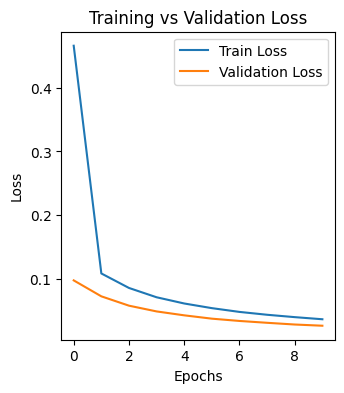

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

## **Plot validation accuracy**

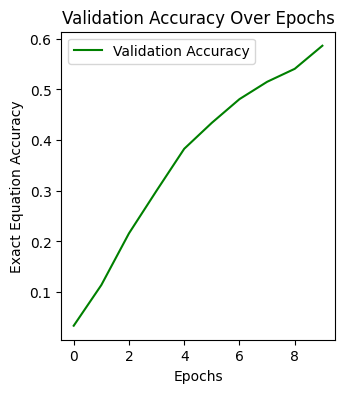

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Exact Equation Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()


## **Plot test accuracy**

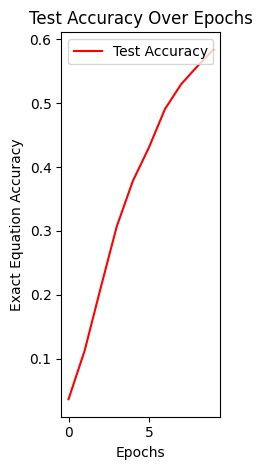

In [8]:
plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label="Test Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Exact Equation Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
def predict_equation(question):
    model.eval()
    inputs = tokenizer(question, return_tensors="pt").to(device)
    output_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [11]:
print("Prediction Example:")
print(predict_equation("A car rents for 30 dollars per day plus 18 cents per mile . You are on a budget of 75 dollars . What mileage would allow you to stay within your budget ?"))

Prediction Example:
x=(75.0-(30.0*0.01))/(18.0*0.01)


In [12]:
print("Prediction Example:")
print(predict_equation("On Friday, John paid $ 5.92 each on 2 tickets to a movie theater. He also borrowed a movie for $ 6.79. John paid with a $ 20 bill. How much change did John receive?"))

Prediction Example:
x=20-(2*5.92)-6.79


In [13]:
print("Prediction Example:")
print(predict_equation("A game was played by a trivia team that consisted of 12 members, although 4 were not present. How many points did the team earn as a whole, given that each present member scored 8 points"))

Prediction Example:
X=(8.0*(12.0-4.0))
